In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from asteroid.models.base_models import BaseModel
import numpy as np
import pandas as pd
import librosa as lr
import soundfile as sf
import matplotlib.pyplot as plt
import time
import os
import os.path
import sys

from librosa import display as lrd
from concurrent.futures import ProcessPoolExecutor
from collections import OrderedDict
from functools import partial
from torch.multiprocessing import Process, Queue, cpu_count
from queue import Empty

from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, FixedMixtureSet
from tqdm import trange, tqdm

from asteroid import DCUNet, DCCRNet, DPRNNTasNet, ConvTasNet, RegressionFCNN, WaveUNet, DPTNet, Demucs, SMoLnet
from asteroid.engine.system import System, UNetGAN

from asteroid.masknn import UNetGANGenerator, UNetGANDiscriminator
from asteroid.utils.notebook_utils import show_wav

sys.path.append('../egs')

from timit_drones.evaluate import evaluate_model

%load_ext autoreload
%autoreload 2

In [2]:
TIMIT_DIR_8kHZ = '/import/vision-eddydata/dm005_tmp/TIMIT_8kHZ'
TEST_NOISE_DIR = '../../../datasets/noises-test-drones'
SAMPLE_RATE    = 8000
TEST_SNRS      = [-30, -25, -20, -15, -10, -5, 0]
SEED           = 42

In [3]:
timit_test_clean = TimitDataset(TIMIT_DIR_8kHZ, subset='test', sample_rate=SAMPLE_RATE, with_path=False)
timit_small = Subset(timit_test_clean, np.arange(len(timit_test_clean)//20))
noises_test = CachedWavSet(TEST_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

Precaching audio: 100%|██████████| 2/2 [00:00<00:00, 174.21it/s]


140.0 s


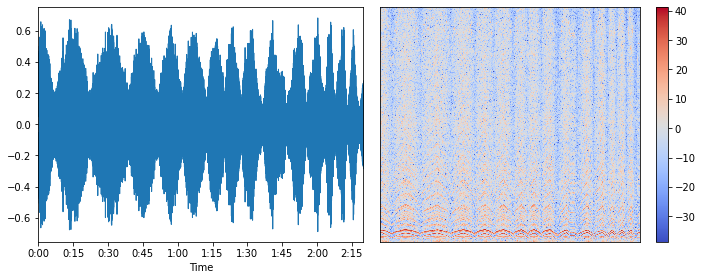

130.0 s


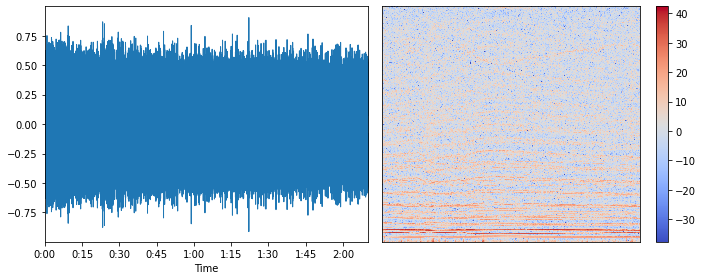

In [4]:
for noise in noises_test:
    print(f'{len(noise) / SAMPLE_RATE} s')
    show_wav(noise)

In [5]:
timit_test_small = FixedMixtureSet(timit_small, noises_test, snrs=TEST_SNRS, random_seed=SEED, with_snr=True)
timit_test = FixedMixtureSet(timit_test_clean, noises_test, snrs=TEST_SNRS, random_seed=SEED, with_snr=True)

In [28]:
metrics_names = {
    'pesq': 'PESQ',
    'stoi': 'STOI',
    'si_sdr': 'SI-SDR',
}

model_labels = {
    'input': 'Input',
    'baseline': 'Baseline DNN',
    'baseline_1024': 'Baseline DNN v2',
    'baseline_v2': 'Baseline DNN (L1 loss)',
    'baseline_proper_mse': 'Baseline DNN (fixed test set)',
    'waveunet_v1': 'Wave-U-Net',
    'dcunet_20': 'DCUNet-20',
    'dccrn': 'DCCRN',
    'dccrn_1024': 'DCCRN v2',
    'smolnet': 'SMoLnet',
    'smolnet_1024': 'SMoLnet v2',
    'dprnn': 'DPRNN',
    'conv_tasnet': 'Conv-TasNet',
    'dptnet': 'DPTNet',
    'demucs': 'Demucs',
    'demucs_full': 'Demucs (full)',
    'unetgan': 'UNetGAN',
    'unetgan-nogan': 'UNetGAN generator (MSE loss only)'
}

def aggregate_results(dfs, metrics=['pesq', 'stoi', 'si_sdr']):
    return {
        name: df.groupby('snr').agg({
            metric: ['mean', 'std', 'count'] for metric in metrics
        })
        for name, df in dfs.items()
    }
    

def plot_results(dfs, figsize=(15, 5), metrics=['pesq', 'stoi', 'si_sdr'],
                 plot_name=None, legend=True, **kwargs): 
    
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=figsize)
    all_scores = aggregate_results(dfs, metrics)
    
    for model_name, scores in all_scores.items():
        line_kwargs = {'marker': 'o', 'alpha': 0.8}
        fill_kwargs = {}
        if model_name == 'input':
            line_kwargs = {'c': 'black', 'ls': '--'}
            fill_kwargs = {'color': 'black'}
        
        for i, metric in enumerate(metrics):
            plt.sca(axes[i])
            means = scores[metric]['mean']
            stds = scores[metric]['std'].values / np.sqrt(scores[metric]['count'].values) * 3
            xs = means.index
            plt.plot(xs, means, label=model_labels[model_name], **line_kwargs)
            plt.fill_between(xs, means - stds, means + stds, alpha=0.2, **fill_kwargs)
    
    for i, metric in enumerate(metrics):
        plt.sca(axes[i])
        plt.grid(which='both')
        plt.title(metrics_names[metric])
        plt.xlabel('SNR, dB')
        if legend and i == len(metrics) - 1:
            plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    if plot_name is not None:
        plt.savefig(plot_name, bbox_inches='tight')
    
    plt.show()
    
    
def highlight_max(s): 
    if s.dtype == np.object: 
        is_max = [False for _ in range(s.shape[0])] 
    else: 
        is_max = s == s.max() 
    return ['font-weight: bold' if cell else '' for cell in is_max] 


def avg_results_table(dfs, models, metrics=['pesq', 'stoi', 'si_sdr']):
    total_df = pd.DataFrame(columns=['Model', 'N. of params'] + [metrics_names[m] for m in metrics])
    for model_name, df in dfs.items():
        model = models[model_name]
        if model is not None:
            param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
            param_approx = np.around(param_count / 1000000, decimals=2)
        else:
            param_approx = None

        total_df.loc[len(total_df)] = [model_labels[model_name], f'{param_approx}M'] + list(df[metrics].mean(axis=0))

    total_df = total_df.style.apply(highlight_max)
    return total_df
        

In [7]:
def demonstrate_models_on_sample(models, mix, clean, **kwargs):
    print('Clean speech')
    show_wav(clean, **kwargs)
    
    for model_name, model in models.items():
        if model is None:
            print('Noisy mixture')
            show_wav(mix, **kwargs)
        else:
            model.eval()
            print(model_labels[model_name])
            show_wav(model(mix).flatten(), **kwargs)

### Models evaluation

In [23]:
unetgan_nogan = UNetGAN()

system = System.load_from_checkpoint(
    '../../../workspace/logs/UNetGAN-generator-pretrain/version_1/checkpoints/epoch=44-val_loss=0.00.ckpt',
    model=unetgan_nogan.generator,
    optimizer=torch.optim.Adam(unetgan_nogan.generator.parameters(), lr=1e-3), loss_func=F.mse_loss,
    train_loader=DataLoader(timit_test_small),
    val_loader=DataLoader(timit_test_small))

unetgan_finetuned = UNetGAN.load_from_checkpoint(
    '../../../workspace/logs/UNetGAN-pretrained-gen/version_1/checkpoints/epoch=35-val_loss=0.00.ckpt')

dccrn_1024 = DCCRNet("DCCRN-CL", stft_kernel_size=1024, stft_n_filters=1024, stft_stride=256, sample_rate=8000)
system_dccrn_1024 = System.load_from_checkpoint(
    '../../../workspace/logs/DCCRNet/stft1024/checkpoints/epoch=88-val_loss=-8.90.ckpt',
    model=dccrn_1024,
    optimizer=torch.optim.Adam(dccrn_1024.parameters(), lr=1e-3), loss_func=None,
    train_loader=None,
    val_loader=None)

all_models = {
    'input': None,
    'baseline': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v1.pt'),
    'baseline_1024': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_stft1024.pt'),
    #'baseline_v2': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v2.pt'),
    #'baseline_proper_mse': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_fixed_mse.pt'),
    'waveunet_v1': WaveUNet.from_pretrained('../../../workspace/models/waveunet_model_adapt.pt'),
    'dcunet_20': DCUNet.from_pretrained('../../../workspace/models/dcunet_20_random_v2.pt'),
    'dccrn': DCCRNet.from_pretrained('../../../workspace/models/dccrn_random_v1.pt'),
    'dccrn_1024': dccrn_1024,
    'smolnet': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet.pt'),
    'smolnet_1024': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_stft1024.pt'),
    'dprnn': DPRNNTasNet.from_pretrained('../../../workspace/models/dprnn_model.pt'),
    'conv_tasnet': ConvTasNet.from_pretrained('../../../workspace/models/convtasnet_model.pt'),
    'dptnet': DPTNet.from_pretrained('../../../workspace/models/dptnet_model.pt'),
    'demucs': Demucs.from_pretrained('../../../workspace/models/Demucs.pt'),
    'demucs_full': Demucs.from_pretrained('../../../workspace/models/Demucs_full.pt'),
    'unetgan-nogan': unetgan_nogan,
    'unetgan': unetgan_finetuned,
}

In [9]:
def eval_all(models, test_set, directory, metrics=['pesq', 'stoi', 'si_sdr'], subset_ixs=None, **kwargs):
    results_dfs = {}
    os.makedirs(directory, exist_ok=True)
    
    for model_name, model in models.items():
        print(f'Evaluating {model_labels[model_name]}')
        csv_path = f'{directory}/{model_name}.csv'

        if os.path.isfile(csv_path):
            print('Results already available')
            df = pd.read_csv(csv_path)
        else:
            df = evaluate_model(model, test_set, metrics=metrics, **kwargs)
            df.to_csv(csv_path, index=False)

        if subset_ixs is not None:
            df = df[subset_ixs]
            
        results_dfs[model_name] = df
        
    return results_dfs

def eval_all_and_plot(models, test_set, directory, plot_name=None, figsize=(14,8),
                      metrics=['pesq', 'stoi', 'si_sdr'], **kwargs):
    results_dfs = eval_all(models, test_set, directory, metrics=metrics, **kwargs)
    plot_results(results_dfs, metrics=metrics, figsize=figsize, plot_name=plot_name, **kwargs)
    return avg_results_table(results_dfs, models)

In [30]:
models = {
    k: all_models[k] for k in 
    ['input', 'baseline', 'smolnet', 'dcunet_20', 'dccrn', 'waveunet_v1', 'demucs', 'conv_tasnet', 'dprnn', 'dptnet', 'unetgan']
}

tf_models = {
    k: all_models[k] for k in 
    ['input', 'baseline', 'smolnet', 'dcunet_20', 'dccrn']
}

wave_models = {
    k: all_models[k] for k in 
    ['input', 'baseline', 'waveunet_v1', 'demucs', 'unetgan']
}

tasnet_models = {
    k: all_models[k] for k in 
    ['input', 'baseline', 'conv_tasnet', 'dprnn', 'dptnet']
}

best_only = {
    k: all_models[k] for k in 
    ['input', 'smolnet', 'dcunet_20', 'waveunet_v1', 'dptnet']
}

tf_1024 = {
    k: all_models[k] for k in 
    ['input', 'baseline', 'baseline_1024', 'smolnet', 'smolnet_1024', 'dcunet_20', 'dccrn', 'dccrn_1024']
}

unetgans_comp = {
     k: all_models[k] for k in 
    ['input', 'waveunet_v1', 'unetgan-nogan', 'unetgan']
}

In [13]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [25]:
mix, clean, snr = timit_test[3360*3+1]
print(snr)

-15


Clean speech


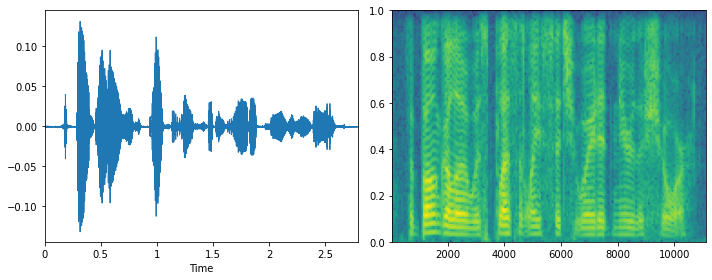

Noisy mixture


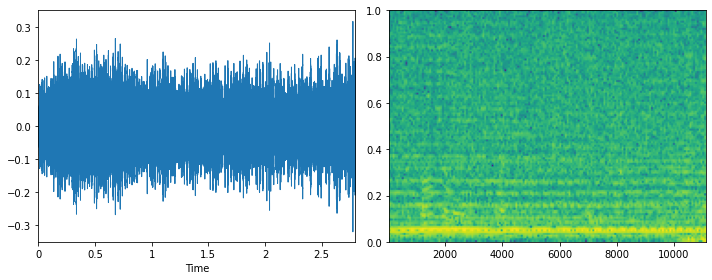

Baseline DNN


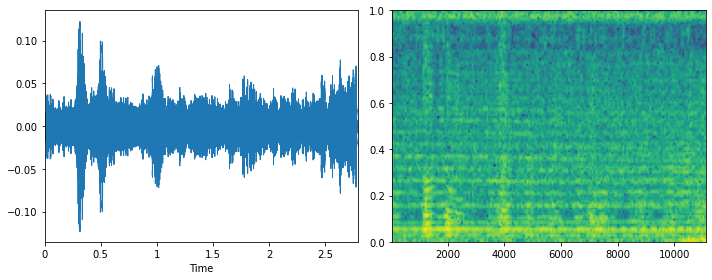

Baseline DNN v2


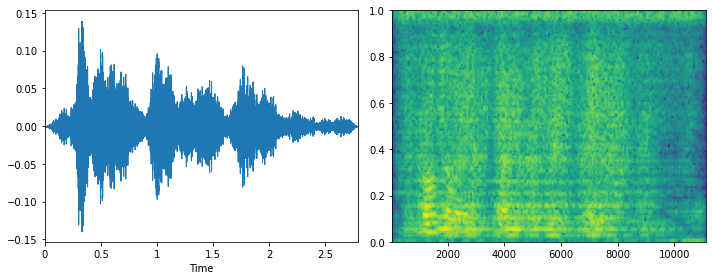

SMoLnet


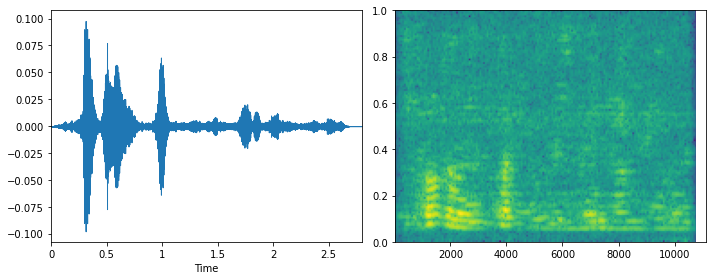

SMoLnet v2


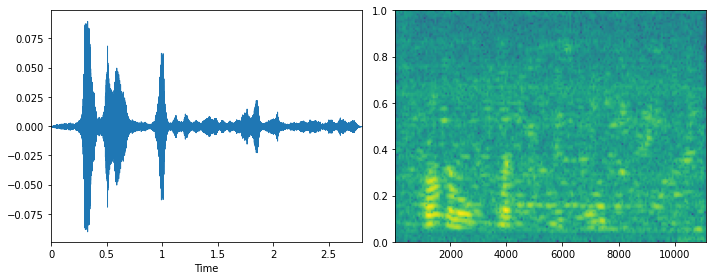

DCUNet-20


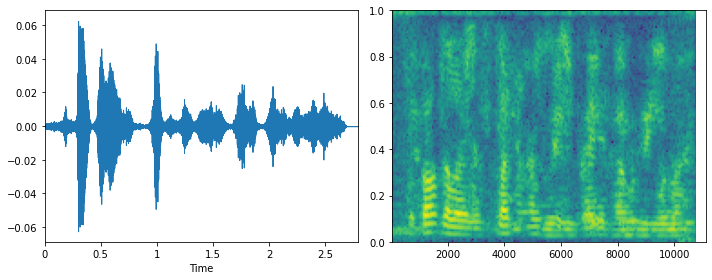

DCCRN


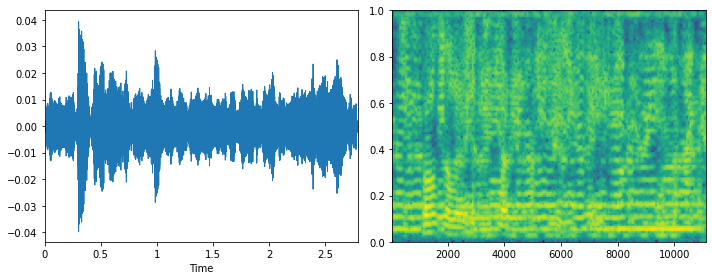

DCCRN v2


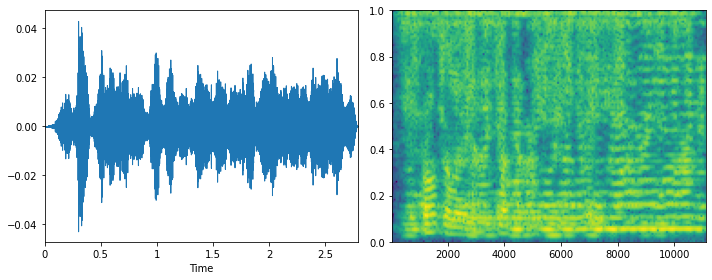

In [31]:
demonstrate_models_on_sample(tf_1024, mix, clean, specgram_lib='matplotlib')

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating SMoLnet
Results already available
Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating Demucs
Results already available
Evaluating Conv-TasNet
Results already available
Evaluating DPRNN
Results already available
Evaluating DPTNet
Results already available
Evaluating UNetGAN
Results already available


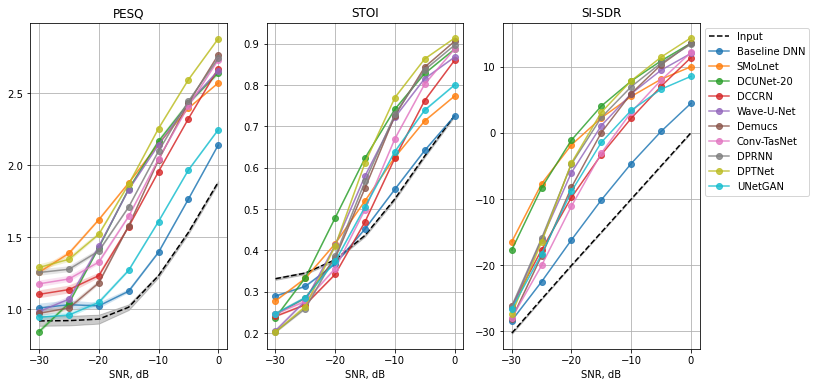

In [13]:
df = eval_all_and_plot(models, timit_test, '../../../workspace/eval_results_final',
                       figsize=(12,6), plot_name='results_final_pypesq.pdf', use_pypesq=True, num_workers=10)
df

In [83]:
print(df.data.to_latex())

\begin{tabular}{lllrrr}
\toprule
{} &         Model & N. of params &      PESQ &      STOI &     SI-SDR \\
\midrule
0  &         Input &        NoneM &  1.204126 &  0.481292 & -15.056471 \\
1  &  Baseline DNN &       10.51M &  1.354869 &  0.476567 & -11.010651 \\
2  &       SMoLnet &        0.22M &  1.894155 &  0.522545 &  -0.006810 \\
3  &     DCUNet-20 &        3.53M &  1.769597 &  0.589930 &   1.325153 \\
4  &         DCCRN &        3.67M &  1.713691 &  0.509330 &  -5.184807 \\
5  &    Wave-U-Net &       10.13M &  1.792482 &  0.554425 &  -2.878122 \\
6  &        Demucs &       18.87M &  1.710713 &  0.562395 &  -3.575446 \\
7  &   Conv-TasNet &        4.98M &  1.791812 &  0.533839 &  -5.548224 \\
8  &         DPRNN &        3.64M &  1.847198 &  0.553839 &  -1.937900 \\
9  &        DPTNet &        8.52M &  1.964783 &  0.576450 &  -1.643701 \\
10 &       UNetGAN &       10.26M &  1.434173 &  0.512686 &  -5.230649 \\
\bottomrule
\end{tabular}



Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating SMoLnet
Results already available
Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available


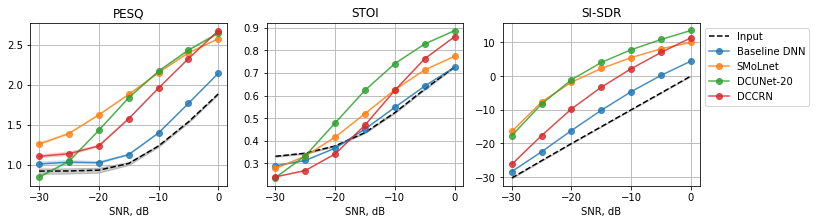

In [51]:
eval_all_and_plot(tf_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(12,3), plot_name='results_final_tf_pypesq.pdf', use_pypesq=True, num_workers=10)

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating Demucs
Results already available
Evaluating UNetGAN
Results already available


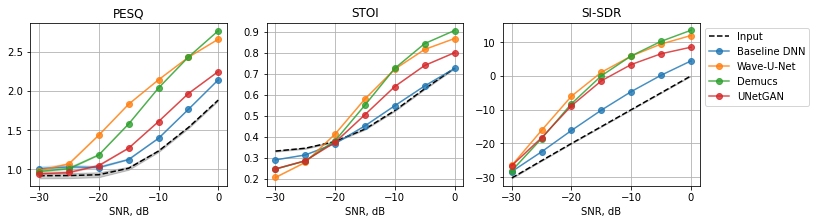

In [52]:
eval_all_and_plot(wave_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(12,3), plot_name='results_final_wave_pypesq.pdf', use_pypesq=True, num_workers=10)

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Conv-TasNet
Results already available
Evaluating DPRNN
Results already available
Evaluating DPTNet
Results already available


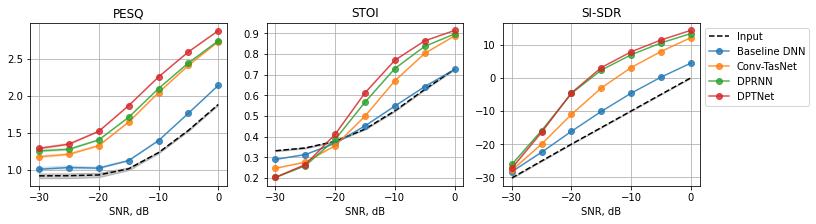

In [53]:
eval_all_and_plot(tasnet_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(12,3), plot_name='results_final_tasnet_pypesq.pdf', use_pypesq=True, num_workers=10)

Evaluating Input
Results already available
Evaluating SMoLnet
Results already available
Evaluating DCUNet-20
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating DPTNet
Results already available


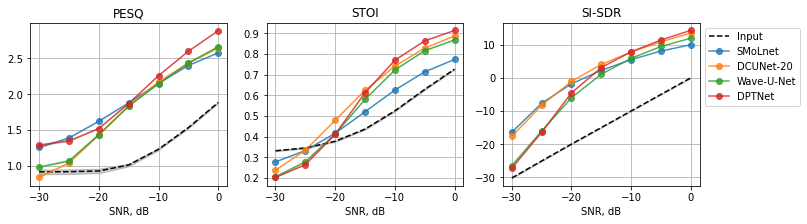

In [55]:
eval_all_and_plot(best_only, timit_test, '../../../workspace/eval_results_final',
                  figsize=(12,3), plot_name='results_final_best_pypesq.pdf', use_pypesq=True, num_workers=10)

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Baseline DNN v2
Results already available
Evaluating SMoLnet
Results already available
Evaluating SMoLnet v2
Results already available
Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available
Evaluating DCCRN v2
Results already available


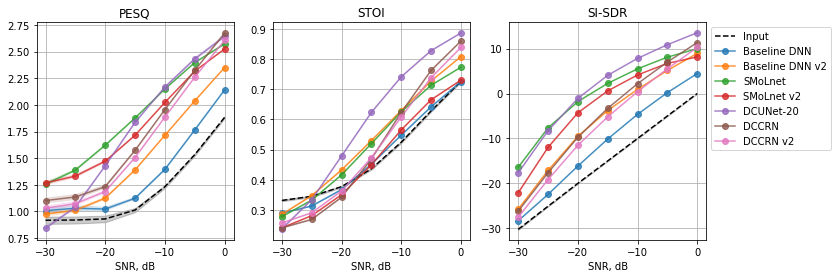

In [33]:
eval_all_and_plot(tf_1024, timit_test, '../../../workspace/eval_results_final',
                  figsize=(12,4), plot_name='results_final_tf1024_pypesq.pdf', use_pypesq=True, num_workers=10)

Evaluating Input
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating UNetGAN generator (MSE loss only)
Results already available
Evaluating UNetGAN
Results already available


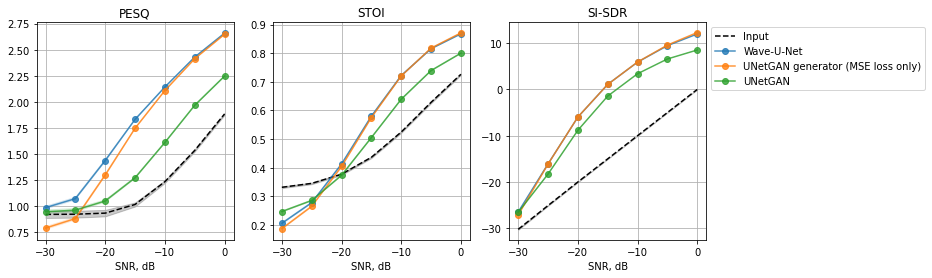

In [22]:
eval_all_and_plot(unetgans_comp, timit_test, '../../../workspace/eval_results_final',
                  figsize=(12,4), plot_name='results_final_unetgan_pypesq.pdf', use_pypesq=True, num_workers=10)

In [61]:
all_results = eval_all(models, timit_test, '../../../workspace/eval_results_final', use_pypesq=True, num_workers=10)

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating SMoLnet
Results already available
Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating Demucs
Results already available
Evaluating Conv-TasNet
Results already available
Evaluating DPRNN
Results already available
Evaluating DPTNet
Results already available
Evaluating UNetGAN
Results already available


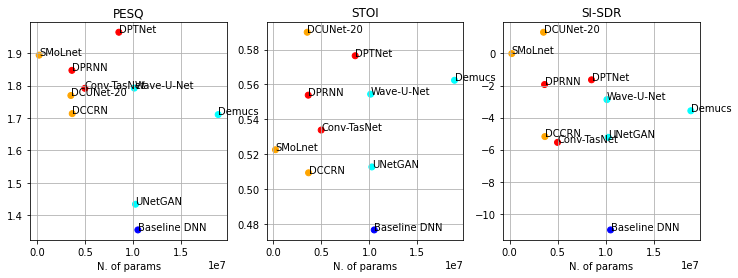

In [79]:
metrics = ['pesq', 'stoi', 'si_sdr']
mean_results = {k: df[metrics].mean(axis=0) for k, df in all_results.items() if k != 'input'}
model_sizes = {
    k: sum(p.numel() for p in all_models[k].parameters() if p.requires_grad)
    for k in mean_results.keys()
}

fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(12, 4))

def make_color(name):
    if name == 'baseline':
        return 'blue'
    if name in ['smolnet', 'dcunet_20', 'dccrn']:
        return 'orange'
    if name in ['waveunet_v1', 'demucs', 'unetgan']:
        return 'cyan'
    else:
        return 'red'
    
colors = [make_color(k) for k in model_sizes.keys()]

for i, metric in enumerate(metrics):
    plt.sca(axes[i])
    plt.grid(which='both')
    plt.title(metrics_names[metric])
    plt.xlabel('N. of params')
    xs = list(model_sizes.values())
    ys = [mean_results[k][metric] for k in model_sizes.keys()]
    plt.scatter(xs, ys, c=colors)
    
    for i, key in enumerate(model_sizes.keys()):
        plt.annotate(model_labels[key], (xs[i], ys[i]), fontsize='medium')

plt.savefig('scores_against_params.pdf', bbox_inches='tight')

Evaluating Input
Results already available


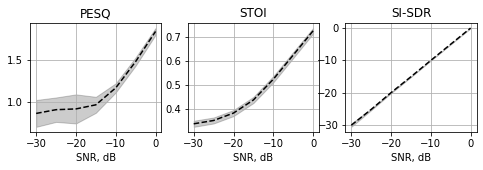

In [95]:
eval_all_and_plot({'input': None}, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  plot_name='pesq_variance.pdf', figsize=(8, 2), num_workers=10, use_pypesq=True, legend=False)

In [14]:
import timeit

def time_evaluate_cpu(models, number=1):
    orig_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    with torch.no_grad():
        inp = torch.rand(24000)
        times = {}
        for name, model in models.items():
            if model is None:
                continue
            model.eval()
            times[name] = timeit.timeit('_ = model(inp)', number=number, globals=locals()) / number

    torch.set_num_threads(orig_threads)
    return times

In [139]:
%%time
cpu_times = time_evaluate_cpu(models, number=100)
cpu_times

CPU times: user 10min 22s, sys: 2.9 s, total: 10min 24s
Wall time: 11min 39s


{'baseline': 0.06354000891005854,
 'smolnet': 0.24797675987007095,
 'dcunet_20': 1.000901500180189,
 'dccrn': 0.562755358540162,
 'waveunet_v1': 0.1990493950402015,
 'demucs': 0.2579579211000237,
 'conv_tasnet': 1.4533383116099867,
 'dprnn': 0.9503612825198797,
 'dptnet': 2.0866141501802487,
 'unetgan': 0.17091383085004053}

In [30]:
import pickle

# with open('model_cpu_times.pt', 'wb') as f:
#     pickle.dump(cpu_times, f)
with open('model_cpu_times.pt', 'rb') as f:
    cpu_times = pickle.load(f)

In [15]:
def time_evaluate_gpu(models, number=1):
    with torch.no_grad():
        inp = torch.rand(24000).cuda()
        times = {}
        for name, model in models.items():
            if model is None:
                continue
            model = model.cuda()
            model.eval()
            m_times = []
            for n in range(number):
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)
                
                start.record()
                _ = model(inp)
                end.record()
                
                torch.cuda.synchronize()
                m_times.append(start.elapsed_time(end))
                
            model = model.cpu()
            times[name] = np.mean(m_times)
    return times


In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
gpu_times = time_evaluate_gpu(models, number=1000)
gpu_times

{'baseline': 1.2966130890846252,
 'smolnet': 4.445486210823059,
 'dcunet_20': 25.61369012451172,
 'dccrn': 47.23087164306641,
 'waveunet_v1': 10.329219012260436,
 'demucs': 10.557093651771545,
 'conv_tasnet': 25.97586277961731,
 'dprnn': 48.52562495422363,
 'dptnet': 66.45751320266723,
 'unetgan': 11.502069409370423}

In [27]:
# with open('model_gpu_times.pt', 'wb') as f:
#     cpu_times = pickle.dump(gpu_times, f)

In [31]:
cpu_times

{'baseline': 0.06354000891005854,
 'smolnet': 0.24797675987007095,
 'dcunet_20': 1.000901500180189,
 'dccrn': 0.562755358540162,
 'waveunet_v1': 0.1990493950402015,
 'demucs': 0.2579579211000237,
 'conv_tasnet': 1.4533383116099867,
 'dprnn': 0.9503612825198797,
 'dptnet': 2.0866141501802487,
 'unetgan': 0.17091383085004053}

In [34]:
df = pd.DataFrame(columns=['Model', 'CPU', 'GPU'], index=np.arange(len(cpu_times)))
df['Model'] = [model_labels[m] for m in cpu_times.keys()]
df['CPU'] = [np.round(s * 1000, 2) for s in cpu_times.values()]
df['GPU'] = [np.round(ms, 2) for ms in gpu_times.values()]

In [35]:
df

Model      CPU    GPU
0  Baseline DNN    63.54   1.30
1       SMoLnet   247.98   4.45
2     DCUNet-20  1000.90  25.61
3         DCCRN   562.76  47.23
4    Wave-U-Net   199.05  10.33
5        Demucs   257.96  10.56
6   Conv-TasNet  1453.34  25.98
7         DPRNN   950.36  48.53
8        DPTNet  2086.61  66.46
9       UNetGAN   170.91  11.50

In [36]:
print(df.to_latex())

\begin{tabular}{llrr}
\toprule
{} &         Model &      CPU &    GPU \\
\midrule
0 &  Baseline DNN &    63.54 &   1.30 \\
1 &       SMoLnet &   247.98 &   4.45 \\
2 &     DCUNet-20 &  1000.90 &  25.61 \\
3 &         DCCRN &   562.76 &  47.23 \\
4 &    Wave-U-Net &   199.05 &  10.33 \\
5 &        Demucs &   257.96 &  10.56 \\
6 &   Conv-TasNet &  1453.34 &  25.98 \\
7 &         DPRNN &   950.36 &  48.53 \\
8 &        DPTNet &  2086.61 &  66.46 \\
9 &       UNetGAN &   170.91 &  11.50 \\
\bottomrule
\end{tabular}



Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating SMoLnet
Results already available
Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating Demucs
Results already available
Evaluating Conv-TasNet
Results already available
Evaluating DPRNN
Results already available
Evaluating DPTNet
Results already available
Evaluating UNetGAN
Results already available


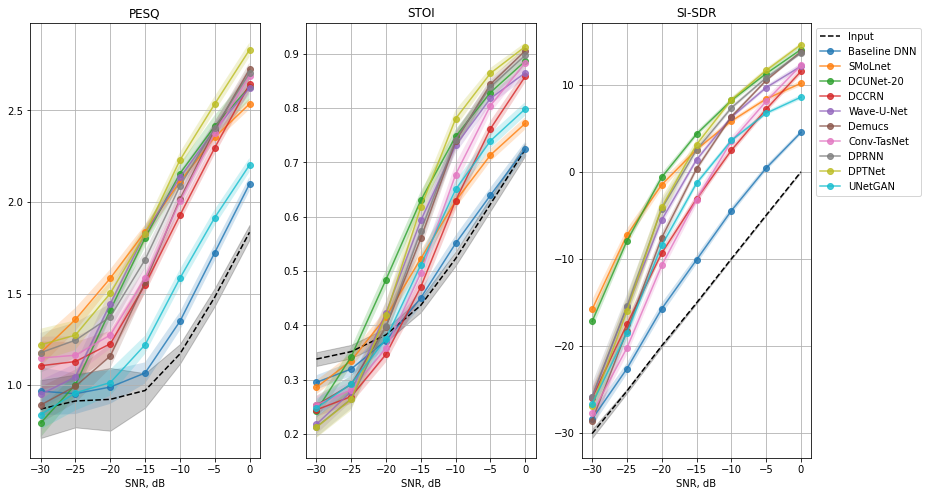

In [90]:
eval_all_and_plot(models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  plot_name='results_new_small.pdf', num_workers=10, use_pypesq=True)

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating DCUNet-20
Results already available
Evaluating SMoLnet
Results already available
Evaluating DPTNet
Results already available
Evaluating UNetGAN generator (MSE loss only)
Results already available
Evaluating UNetGAN
Results already available


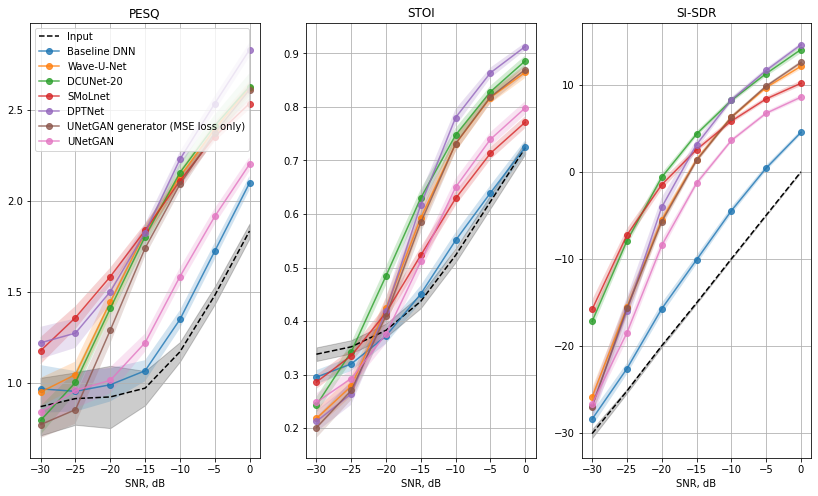

In [17]:
fewer_models = {
    k: models[k] for k in 
    ['input', 'baseline', 'waveunet_v1', 'dcunet_20', 'smolnet', 'dptnet', 'unetgan-nogan', 'unetgan']
}

eval_all_and_plot(fewer_models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  plot_name='results_new_small.pdf', num_workers=5, use_pypesq=True)